<a href="https://colab.research.google.com/github/alirezaght/iran-bank-card-ocr/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install yolov5

In [2]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 10222, done.
remote: Total 10222 (delta 0), reused 0 (delta 0), pack-reused 10222
Receiving objects: 100% (10222/10222), 10.54 MiB | 24.92 MiB/s, done.
Resolving deltas: 100% (7060/7060), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.4 MB/s 
Setup complete. Using torch 1.10.0+cu111 (Tesla K80)


In [3]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Prepare data

Check the graphic driver

In [4]:
!nvidia-smi

Thu Dec 16 06:47:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set Path

In [5]:
%cd /content
!mkdir notebook
%cd notebook
!cp /content/drive/MyDrive/Colab\ Notebooks/data.zip .
!unzip data.zip

/content
/content/notebook
Archive:  data.zip
   creating: images/
   creating: labels/
  inflating: classes.txt             
  inflating: notes.json              
  inflating: images/12dfb7fd-ca775214-t6_8df9.jpg  
  inflating: images/3c46be46-069976eb-images-48_14aa.jpg  
  inflating: images/bb44db6e-d5c91c5f-IMG_9586_1a1b.jpg  
  inflating: images/95424d11-images-81_1b94.jpeg  
  inflating: images/f0b35391-c172_bb05.jpg  
  inflating: images/3b30ced6-d225f50b-Unknown-3_9aab.jpg  
  inflating: images/666f188b-images-67_421f.jpeg  
  inflating: images/22cce1b1-9dfd0f59-1_3030.jpg  
  inflating: images/55e8945b-0af89616-credit_card_PNG180_473b.jpg  
  inflating: images/16106007-43792e3b-credit_card_PNG236_17d2.jpg  
  inflating: images/ca98ebe1-f4ef6914-Unknown-2_3583.jpg  
  inflating: images/7b61eb2e-images-98_42ab.jpeg  
  inflating: images/8aee3dd6-ce86e950-x_2_bd5c.jpg  
  inflating: images/72782537-48573584-IMG_9587_e830.jpg  
  inflating: images/3e1907a9-e5558ac4-credit_card_PNG

In [6]:
path = '/content/notebook'


## Remove unlabeld images


In [7]:
%cd /content
import json

def remove_unlabeled_files():
  labels = os.listdir(f'{path}/labels')
  images = os.listdir(f'{path}/images')
  for image in images:
    found = False
    for label in labels:
      if label.startswith(image.split('-')[0]):
        found = True
        if not label.startswith(image.split('.')[0]):
          os.rename(f'{path}/images/{image}', f'{path}/images/{label.split(".")[0]}.{image.split(".")[-1]}')
          print(f'Renamed {image} to {path}/images/{label.split(".")[0]}.{image.split(".")[-1]}')
        break
    if not found:
      os.remove(f'{path}/images/{image}')
      print(f"Removed file {image}")

remove_unlabeled_files()


/content


## Prepare annotations and images

In [8]:
random.seed(0)

def prepare_labels():
  labels = {}
  notes = open(f'{path}/notes.json')
  categories = json.load(notes)['categories']
  for item in categories:
    labels[item['id']] = item['name']
  return labels

def get_image(label_file):
  list_images = {x.split('.')[0]:x for x in os.listdir(f'{path}/images')}  
  image_name = label_file.split('.')[0]    
  if image_name in list_images:
      return f'{path}/images/{list_images[image_name]}'


class_id_to_name_mapping = prepare_labels()

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

annotations = os.listdir(f'{path}/labels/')

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(f'{path}/labels/{annotation_file}', "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = get_image(annotation_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
# plot_bounding_box(image, annotation_list)

## Prepare train, validation, test set

In [9]:
# Read images and annotations
images = [os.path.join(f'{path}/images', x) for x in os.listdir(f'{path}/images')]
annotations = [os.path.join(f'{path}/labels', x) for x in os.listdir(f'{path}/labels')]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

### Copy to required folders

In [10]:
!mkdir images labels images/train images/val images/test labels/train labels/val labels/test

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            print(f"Copying {f} to {destination_folder}")
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')


Copying /content/notebook/images/4cc04fb2-6ea2064f-_5563.jpg to images/train
Copying /content/notebook/images/ce12fc7f-caec3185-images-21_7a44.jpg to images/train
Copying /content/notebook/images/0f2ec944-a263b9c1-images-90_7d7c.jpg to images/train
Copying /content/notebook/images/632f7a55-c157_1dc4.jpg to images/train
Copying /content/notebook/images/0a6c4379-f545f1a0-images-128_349c.jpg to images/train
Copying /content/notebook/images/7f97f8c2-3e37961c-06_3602.jpg to images/train
Copying /content/notebook/images/aba83e4b-a73c9879-WhatsApp_Image_2021-11-09_at_11.05.20_AM_d2a9.jpg to images/train
Copying /content/notebook/images/b2a02004-46e90a93-credit_card_PNG145_9246.jpg to images/train
Copying /content/notebook/images/d5b2f466-c10_2581.jpg to images/train
Copying /content/notebook/images/175d504a-images-8_a509.jpeg to images/train
Copying /content/notebook/images/48856e61-c025a7cc-images-6_5bd6.jpg to images/train
Copying /content/notebook/images/ed0af0f7-images-42_f351.jpeg to ima

## Prepare the yaml file for yolo

In [11]:
import yaml

scanner_yaml = {"train": "/content/images/train/", "val": "/content/images/val/", "test": "/content/images/test/", "nc": len(class_id_to_name_mapping), "names": list(class_id_to_name_mapping.values())}

with open(r'/content/yolov5/data/scanner.yaml', 'w') as file:
    yaml.dump(scanner_yaml, file)

# Train

In [12]:
%cd /content/yolov5
!rm -rf runs/train/*
!python train.py --img 300 --cfg yolov5n.yaml --hyp hyp.scratch.yaml --batch 64 --epochs 100 --data scanner.yaml --weights yolov5n.pt --workers 24 --name yolo_scanner


/content/yolov5
train: weights=yolov5n.pt, cfg=yolov5n.yaml, data=scanner.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=64, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_scanner, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-147-g628817d torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, 

# Evaluate

In [13]:
!rm -rf runs/detect/*
!python detect.py --source /content/images/test/ --weights runs/train/yolo_scanner/weights/best.pt --conf 0.25 --name yolo_scanner


detect: weights=['runs/train/yolo_scanner/weights/best.pt'], source=/content/images/test/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_scanner, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-147-g628817d torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 1761871 parameters, 0 gradients, 4.2 GFLOPs
image 1/210 /content/images/test/01962d23-e8fd7357-5_52d4.jpg: 416x640 1 pan, Done. (0.016s)
image 2/210 /content/images/test/057a0b52-credit_card_PNG222_98d5.png: 416x640 2 pans, Done. (0.015s)
image 3/210 /content/images/test/06796757-339df6eb-6_c9f0.jpg: 416x640 1 pan, 1 exp, Done. (0.015s)
image 4/210 /content/images/test/071ca566-057a0b52-credit_card_PNG222_ce72.jpg: 416

## Plot randomly

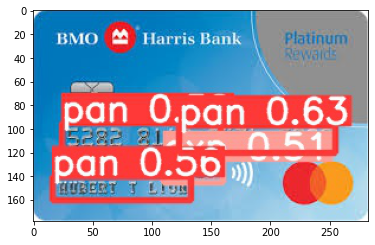

In [28]:
detections_dir = "runs/detect/yolo_scanner/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

## Compute mAP (mean average percision)

In [15]:
!python val.py --weights runs/train/yolo_scanner/weights/best.pt --data scanner.yaml --task test --name yolo_det


val: data=/content/yolov5/data/scanner.yaml, weights=['runs/train/yolo_scanner/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-147-g628817d torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 1761871 parameters, 0 gradients, 4.2 GFLOPs
test: Scanning '/content/labels/test' images and labels...210 found, 0 missing, 0 empty, 0 corrupted: 100% 210/210 [00:00<00:00, 1164.40it/s]
test: WARNING: /content/images/test/d5cea302-idbi-eclat-2_8a70.jpg: corrupt JPEG restored and saved
test: New cache created: /content/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 7/7 [00:06<00:00,  1.14it/s]
                 all        210        378 

In [16]:
!cp runs/train/yolo_scanner/weights/best.pt /content/drive/MyDrive/best.pt